# EDA of Chest-XRays with Thorax labels

Thoracic disorders are conditions of the heart, lungs, mediastinum, esophagus, chest wall, diaphragm and great vessels.

In [1]:
%load_ext autoreload
%autoreload 2

In [56]:
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from PIL import Image

In [3]:
from chest_xray_diagnosis import get_root_path
from chest_xray_diagnosis.data.meta import process

In [35]:
PROJECT_PATH = get_root_path()
METADATA_PATH = os.path.join(PROJECT_PATH, "metadata", "NIH")
DATA_PATH = os.path.join("/scratch", "mittal.nit", "nih-chestxrays", "xrays", "images")

In [38]:
metadata = pd.read_csv(os.path.join(METADATA_PATH, "Data_Entry_2017_v2020.csv"))
metadata.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [39]:
pd.DataFrame(metadata.isna().sum(), columns=["NA count"])

,NA count
Image Index,0
Finding Labels,0
Follow-up #,0
Patient ID,0
Patient Age,0
Patient Gender,0
View Position,0
OriginalImage[Width,0
Height],0
OriginalImagePixelSpacing[x,0


In [42]:
print(f"Number of samples in metadata: {len(metadata)}")
print(f"Number of xray images: {len(np.unique(os.listdir(DATA_PATH)))}")
print(f"Number of unique image indices: {len(metadata['Image Index'].unique())}")
print(f"Number of unique patients : {len(metadata['Patient ID'].unique())}")

Number of samples in metadata: 112120
Number of xray images: 112120
Number of unique image indices: 112120
Number of unique patients : 30805


Since, number of samples > number of unique patients, therefore for single patient we have multiple XRays.

In [9]:
metadata.set_index("Image Index", inplace=True)

In [10]:
metadata.head()

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
Image Index,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [11]:
metadata["Finding Labels"].value_counts()

No Finding                                                                 60361
Infiltration                                                                9547
Atelectasis                                                                 4215
Effusion                                                                    3955
Nodule                                                                      2705
                                                                           ...  
Atelectasis|Consolidation|Effusion|Emphysema|Fibrosis|Mass|Nodule              1
Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Infiltration|Mass        1
Emphysema|Infiltration|Mass|Nodule|Pleural_Thickening                          1
Effusion|Emphysema|Infiltration|Nodule|Pleural_Thickening                      1
Consolidation|Effusion|Infiltration|Mass|Pleural_Thickening                    1
Name: Finding Labels, Length: 836, dtype: int64

<font color="blue">A single patient can have multiple Thorax diseases at once.

## Visualizing distribution of different labels available

In [12]:
# one hot encoding for labels
onehotlabels = process.get_dummies(
    metadata["Finding Labels"],
    validate_io_schema=True)
onehotlabels.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Image Index,,,,,,,,,,,,,,,
00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
00000002_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
00000003_001.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


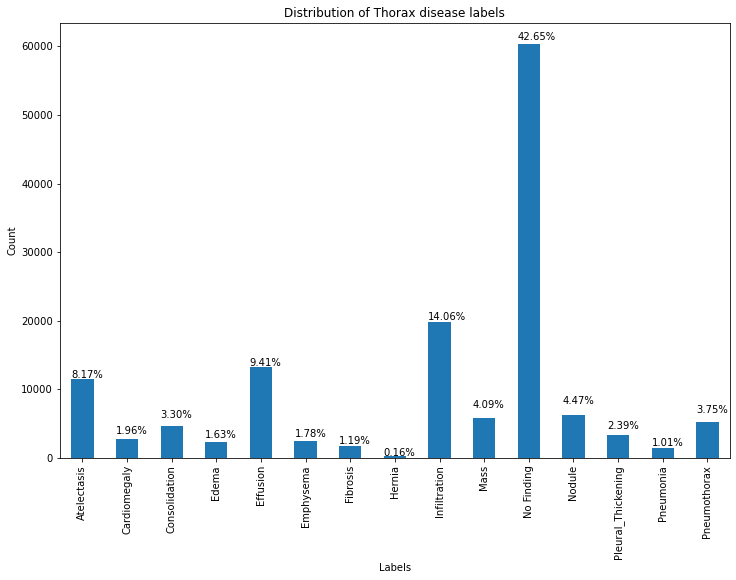

In [13]:
fig, ax = plt.subplots()
onehotlabels.sum(axis=0).plot.bar(ax=ax, figsize=(12,8))
sum_labels = onehotlabels.sum().sum()
for p in ax.patches:
    ax.annotate(
        f"{p.get_height()*100/sum_labels:.2f}%", 
        (p.get_x()*1.0, p.get_height()*1.25 if p.get_height() < 10000 else p.get_height()*1.01), fontsize=10)

ax.set_title("Distribution of Thorax disease labels")
ax.set_ylabel("Count")
ax.set_xlabel("Labels")
plt.show()

<font color="blue"> Non-uniform distribution of labels

## Combining one-hot labels with metadata

In [14]:
metadata_with_onehotlabels = pd.merge(
    metadata,
    onehotlabels,
    left_index=True, 
    right_index=True,
    how="inner")

In [15]:
metadata_with_onehotlabels.head()

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Image Index,,,,,,,,,,,,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,...,1,0,0,0,0,0,0,0,0,0
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,...,0,0,0,0,0,0,0,0,0,0
00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,...,0,0,0,0,0,1,0,0,0,0
00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,...,0,0,1,0,0,0,0,0,0,0


## Understanding correlation between labels

In [16]:
labels = onehotlabels.columns
num_labels = len(labels)
co_ocur_labels = pd.DataFrame(
    np.zeros(
        (num_labels, num_labels), dtype=int),
    columns=onehotlabels.columns, 
    index=onehotlabels.columns)

for values in tqdm(onehotlabels.values, leave=False):
    values = labels[values==1]
    for i in range(len(values)):
        for j in range(i, len(values)):
            co_ocur_labels.loc[values[i]][values[j]] += 1
            if i != j: co_ocur_labels.loc[values[j]][values[i]] += 1

In [17]:
assert np.allclose(co_ocur_labels.values.diagonal(), onehotlabels.sum(axis=0).values)

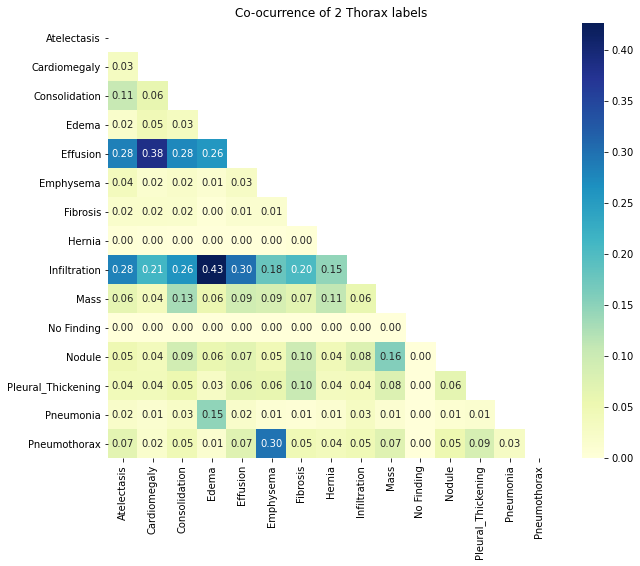

In [18]:
mask = np.zeros_like(co_ocur_labels.values, dtype=np.bool)
mask[np.triu_indices_from(co_ocur_labels.values)] = True

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(co_ocur_labels/co_ocur_labels.max(axis=1), ax=ax, cmap="YlGnBu", mask=mask, annot=True, fmt=".2f")
ax.set_title("Co-ocurrence of any 2 Thorax labels")
plt.show()

## Different views available for X-Rays

In [26]:
metadata_with_onehotlabels["View Position"].value_counts()

PA    67310
AP    44810
Name: View Position, dtype: int64

1. A PA radiograph is obtained with the x-ray traversing the patient from posterior to anterior and striking the film. 
1. An AP radiograph is positioned with the xray traversing the patient from anterior to posterior striking the film.

In [53]:
pa_sample = np.random.choice(metadata_with_onehotlabels[metadata_with_onehotlabels["View Position"]=="PA"].index)
ap_sample = np.random.choice(metadata_with_onehotlabels[metadata_with_onehotlabels["View Position"]=="AP"].index)

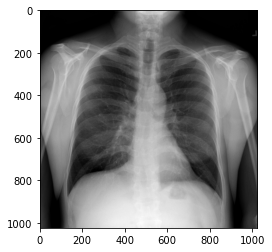

In [62]:
img = mpimg.imread(os.path.join(DATA_PATH, pa_sample))
plt.imshow(img, cmap="gray")
plt.show()

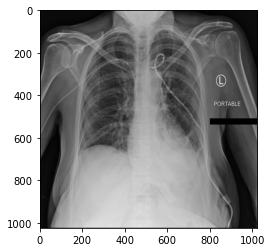

In [63]:
img = mpimg.imread(os.path.join(DATA_PATH, ap_sample))
plt.imshow(img, cmap="gray")
plt.show()

## Visualizing distribution of labels by Gender

In [19]:
labels_by_gend = {}
for label in labels:
    labels_by_gend[label] = metadata_with_onehotlabels[
        metadata_with_onehotlabels[label]==1].groupby("Patient Gender").agg(
        {"Patient ID": pd.Series.nunique}).to_dict()["Patient ID"]
    
labels_by_gend = pd.DataFrame.from_dict(labels_by_gend, orient="index")
labels_by_gend

,F,M
Atelectasis,2062,2919
Cardiomegaly,825,741
Consolidation,906,1244
Edema,491,582
Effusion,1973,2302
Emphysema,380,666
Fibrosis,582,678
Hernia,70,64
Infiltration,3517,4518
Mass,1063,1505


In [20]:
labels_by_gend.sum(axis=0)

F    26775
M    33115
dtype: int64

In [21]:
labels_by_gend.div(labels_by_gend.sum(axis=1), axis=0)

,F,M
Atelectasis,0.413973,0.586027
Cardiomegaly,0.526820,0.473180
Consolidation,0.421395,0.578605
Edema,0.457596,0.542404
Effusion,0.461520,0.538480
Emphysema,0.363289,0.636711
Fibrosis,0.461905,0.538095
Hernia,0.522388,0.477612
Infiltration,0.437710,0.562290
Mass,0.413941,0.586059


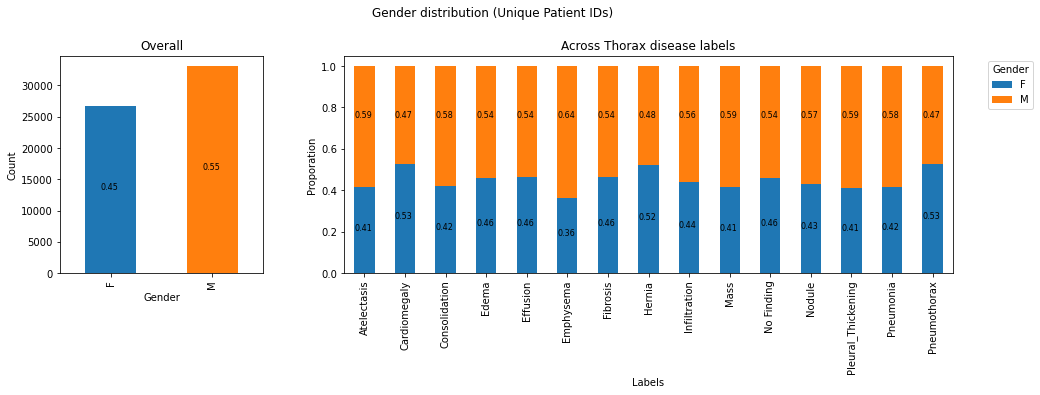

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 3]})
labels_by_gend.sum().plot.bar(ax=ax1, color=['#1f77b4', '#ff7f0e'])
for p in ax1.patches:
    ax1.annotate(
        f"{p.get_height()/labels_by_gend.sum().sum():.2f}", 
        (p.get_x()+.15, p.get_height() * .5),
        fontsize=8)

ax1.set_title("Overall")
ax1.set_ylabel("Count")
ax1.set_xlabel("Gender")
# ax1.set_xticks([])

ax2 = labels_by_gend.div(labels_by_gend.sum(axis=1), axis=0).plot.bar(stacked=True, ax=ax2)
ax2.set_title("Across Thorax disease labels")
ax2.set_ylabel("Proporation")
ax2.set_xlabel("Labels")

l = len(ax2.patches)//2
for i in range(l):
    p1, p2 = ax2.patches[i], ax2.patches[i+l]
    ax2.annotate(
        f"{p1.get_height():.2f}", (p1.get_x() * 1.00, p1.get_height() * .5), fontsize=8)
    ax2.annotate(
        f"{p2.get_height():.2f}", (p2.get_x() * 1.00, (p1.get_height() + p2.get_height()) * .75), fontsize=8)
ax2.legend(bbox_to_anchor=(1.05,1.), title="Gender")

fig.suptitle(t="Gender distribution (Unique Patient IDs)", x=.5, y=1.05, horizontalalignment="center")
plt.show()

In [24]:
metadata_with_onehotlabels["View Position"].value_counts()

PA    67310
AP    44810
Name: View Position, dtype: int64

In [25]:
value_counts

NameError: name 'value_counts' is not defined